In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [110]:
data = pd.read_table("wildfires.txt", delim_whitespace=True)
data['fire'] = data['fire'].map({"yes":1, "no":0})

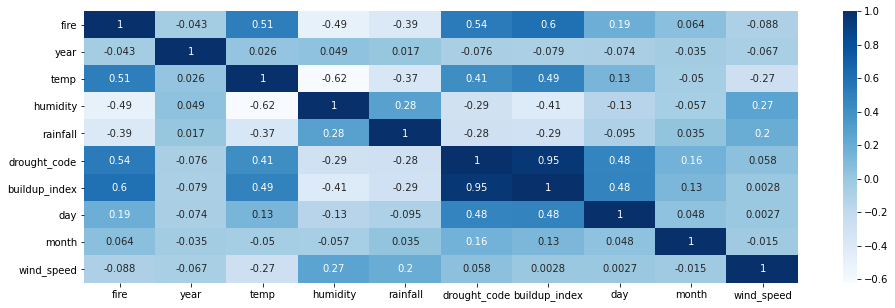

In [111]:
corr = data.corr()
plt.figure(figsize = (16,5))
sns.heatmap(corr, cmap="Blues",annot = True)
plt.savefig("Heatmap")

# Perceptron From Scratch

In [112]:
class Perceptron:
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def __init__(self):
        self.learning_rate = None
        self.epochs = None
        self.weights = None
        self.bias = None

    def fit(self, X_train, Y_train, epochs = 100, learning_rate= 0.00001):
        data_size, vector_size = X_train.shape
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weight = np.random.rand(vector_size)
        self.bias = 0
        for i in range(self.epochs):
            for x, y in zip(X_train, Y_train):
                Y_pred = self.sigmoid(np.dot(x, self.weight) + self.bias)
                self.weight += self.learning_rate * (y - Y_pred) * x
                self.bias += self.learning_rate * (y - Y_pred)

    def predict(self, X):
        return self.sigmoid(np.dot(X, self.weight) + self.bias)

In [113]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.33, random_state = 100)

In [114]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data)
X_test = scaler.transform(test_data)

In [115]:
X_train = train_data[["temp","drought_code","buildup_index"]]
Y_train = train_data[['fire']]
X_test = test_data[["temp","drought_code","buildup_index"]]
Y_test = test_data[['fire']]

In [116]:
X_train = X_train.to_numpy().reshape(X_train.shape[0], 3)
Y_train = Y_train.to_numpy().reshape(Y_train.shape[0],) 
X_test = X_test.to_numpy().reshape(X_test.shape[0], 3)
Y_test = Y_test.to_numpy().reshape(Y_test.shape[0],)

In [117]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
roundoff = lambda x: np.round(x)
cv = KFold(n_splits=5)
models = []
for train, test in cv.split(X_train):
    x_train = X_train[train]
    y_train = Y_train[train]
    x_val = X_train[test]
    y_val = Y_train[test]
    
    p = Perceptron()
    p.fit(x_train, y_train, 100, 0.00001)
    y_pred = roundoff(p.predict(x_val))
    print(accuracy_score(y_val, y_pred))
    models.append(p)

0.8571428571428571
0.7777777777777778
0.7407407407407407
0.8888888888888888
0.7037037037037037


In [123]:
def predictions_cross_val(X_test):
    return np.average([models[0].predict(X_test), 
                   models[1].predict(X_test),
                   models[2].predict(X_test),
                   models[3].predict(X_test),
                   models[4].predict(X_test)])

In [103]:
p = Perceptron()
p.fit(X_train, Y_train, 100, 0.00001)
predictions = p.predict(X_test)

In [104]:
roundoff = lambda x: np.round(x)
Y_pred = roundoff(predictions)

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy_score(Y_pred, Y_test)

0.8382352941176471

In [24]:
confusion_matrix(Y_test, Y_pred)

array([[27,  4],
       [ 7, 30]], dtype=int64)

In [25]:
from sklearn.metrics import roc_curve, auc

perceptron_predicted = predictions
perceptron_actual = Y_test
fpr_perceptron, tpr_preceptron, threshold = roc_curve(Y_test, predictions)
auc_perceptron = auc(fpr_perceptron, tpr_preceptron)

# MLP Classifier from scratch

In [26]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        pass

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        pass

In [27]:
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output
    
    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [28]:
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [29]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [30]:
class Network:
    def __init__(self):
        self.layers = []
        #self.loss = None
        #self.loss_prime = None
    
    def mean_squared_error_derivative(self, Y_true, Y_pred):
        return 2*(Y_pred - Y_true)/ Y_true.size

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)


    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            #err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                #err += self.loss(y_train[j], output)

                # backward propagation
                error = self.mean_squared_error_derivative(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            #err /= samples
            #print('epoch %d/%d   error=%f' % (i+1, epochs, err))

In [31]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.33, random_state = 100)

In [32]:
X_train = train_data[["temp","drought_code","buildup_index"]]
Y_train = train_data[['fire']]
X_test = test_data[["temp","drought_code","buildup_index"]]
Y_test = test_data[['fire']]

In [33]:
X_train = X_train.to_numpy().reshape(X_train.shape[0], 1, 3)
Y_train = Y_train.to_numpy().reshape(Y_train.shape[0],)
X_test = X_test.to_numpy().reshape(X_test.shape[0], 1, 3)
Y_test = Y_test.to_numpy().reshape(Y_test.shape[0],)

In [34]:
net = Network()
net.add(FCLayer(3, 25))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net.add(ActivationLayer(sigmoid, sigmoid_derivative))
net.add(FCLayer(25, 1))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)                   # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(sigmoid, sigmoid_derivative))

In [39]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
roundoff = lambda x: np.round(x)
cv = KFold(n_splits=5)
models = []
for train, test in cv.split(X_train):
    x_train = X_train[train]
    y_train = Y_train[train]
    x_val = X_train[test]
    y_val = Y_train[test]
    
    net.fit(x_train, y_train, epochs = 35, learning_rate = 0.001)
    y_pred = roundoff(p.predict(x_val))
    print(accuracy_score(y_val, y_pred))
    models.append(p)

0.8214285714285714
0.7037037037037037
0.7037037037037037
0.8148148148148148
0.6666666666666666


In [36]:
net.fit(X_train, Y_train, epochs=35, learning_rate=0.001)

In [37]:
Y_pred_array = lambda x: np.round(x)
predictions = np.array(net.predict(X_test)).reshape(68, )
Y_pred = Y_pred_array(predictions)

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
 
accuracy_score(Y_test, Y_pred)

0.8823529411764706

In [40]:
confusion_matrix(Y_test, Y_pred)

array([[23,  8],
       [ 0, 37]], dtype=int64)

In [41]:
from sklearn.metrics import roc_curve, auc

mlp_predicted = predictions
mlp_actual = Y_test
fpr_mlp, tpr_mlp, threshold = roc_curve(Y_test, predictions)
auc_mlp = auc(fpr_mlp, tpr_mlp)

# Perceptron Sklearn for Reference

In [42]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.33, random_state = 100)

In [43]:
X_train = train_data[["temp","drought_code","buildup_index"]]
Y_train = train_data[['fire']]
X_test = test_data[["temp","drought_code","buildup_index"]]
Y_test = test_data[['fire']]

In [44]:
X_train = X_train.to_numpy().reshape(X_train.shape[0], 3)
Y_train = Y_train.to_numpy().reshape(Y_train.shape[0],)
X_test = X_test.to_numpy().reshape(X_test.shape[0], 3)
Y_test = Y_test.to_numpy().reshape(Y_test.shape[0],)

In [47]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron
roundoff = lambda x: np.round(x)
cv = KFold(n_splits=5)
models = []
for train, test in cv.split(X_train):
    x_train = X_train[train]
    y_train = Y_train[train]
    x_val = X_train[test]
    y_val = Y_train[test]
    
    p = Perceptron(alpha = 0.00001)
    p.fit(x_train, y_train)
    y_pred = roundoff(p.predict(x_val))
    print(accuracy_score(y_val, y_pred))
    models.append(p)

0.8571428571428571
0.9259259259259259
0.7777777777777778
0.8888888888888888
0.6666666666666666


In [48]:
from sklearn.linear_model import Perceptron

p = Perceptron(alpha= 0.00001)
p.fit(X_train, Y_train)

Perceptron(alpha=1e-05)

In [49]:
predictions = p.predict(X_test)
Y_pred = Y_pred_array(predictions)

In [50]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
accuracy_score(Y_test, Y_pred)

0.8823529411764706

In [51]:
confusion_matrix(Y_test, Y_pred)

array([[24,  7],
       [ 1, 36]], dtype=int64)

In [52]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.77      0.86        31
           1       0.84      0.97      0.90        37

    accuracy                           0.88        68
   macro avg       0.90      0.87      0.88        68
weighted avg       0.89      0.88      0.88        68



In [53]:
from sklearn.metrics import roc_curve, auc

perceptron_sklearn_predicted = predictions
Y_pred = Y_pred_array(predictions)
perceptron_sklearn_actual = Y_test
fpr_sk_perceptron, tpr_sk_perceptron, threshold = roc_curve(Y_test, predictions)
auc_sk_perceptron = auc(fpr_sk_perceptron, tpr_sk_perceptron)

# MLP Sklearn for reference

In [54]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.33, random_state = 100)

In [55]:
X_train = train_data[["temp","drought_code","buildup_index"]]
Y_train = train_data[['fire']]
X_test = test_data[["temp","drought_code","buildup_index"]]
Y_test = test_data[['fire']]

In [56]:
X_train = X_train.to_numpy().reshape(X_train.shape[0], 3)
Y_train = Y_train.to_numpy().reshape(Y_train.shape[0],)
X_test = X_test.to_numpy().reshape(X_test.shape[0], 3)
Y_test = Y_test.to_numpy().reshape(Y_test.shape[0],)

In [57]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
roundoff = lambda x: np.round(x)
cv = KFold(n_splits=5)
models = []
for train, test in cv.split(X_train):
    x_train = X_train[train]
    y_train = Y_train[train]
    x_val = X_train[test]
    y_val = Y_train[test]
    
    mlp= MLPClassifier(solver = 'sgd', hidden_layer_sizes = (30, ) ,alpha= 0.000001)
    p.fit(x_train, y_train)
    y_pred = roundoff(p.predict(x_val))
    print(accuracy_score(y_val, y_pred))
    models.append(p)

0.8571428571428571
0.9259259259259259
0.7777777777777778
0.8888888888888888
0.6666666666666666


In [58]:
from sklearn.neural_network import MLPClassifier

mlp= MLPClassifier(solver = 'sgd', hidden_layer_sizes = (30, ) ,alpha= 0.000001)
mlp.fit(X_train, Y_train)

C:\Users\Smitesh\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=1e-06, hidden_layer_sizes=(30,), solver='sgd')

In [59]:
predictions = mlp.predict(X_test)
Y_pred = Y_pred_array(predictions)

In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(Y_test, Y_pred)

0.8529411764705882

In [61]:
confusion_matrix(Y_test, Y_pred)

array([[26,  5],
       [ 5, 32]], dtype=int64)

In [62]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84        31
           1       0.86      0.86      0.86        37

    accuracy                           0.85        68
   macro avg       0.85      0.85      0.85        68
weighted avg       0.85      0.85      0.85        68



In [63]:
from sklearn.metrics import roc_curve, auc

mlp_sklearn_predicted = predictions
mlp_sklearn_actual = Y_test
fpr_sk_mlp, tpr_sk_mlp, threshold = roc_curve(Y_test, predictions)
auc_sk_mlp = auc(fpr_sk_mlp, tpr_sk_mlp)

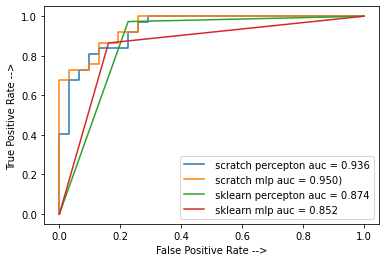

In [64]:
plt.plot(fpr_perceptron, tpr_preceptron, linestyle='-', label=' scratch percepton auc = %0.3f' % auc_perceptron)
plt.plot(fpr_mlp, tpr_mlp, linestyle='-', label=' scratch mlp auc = %0.3f)' % auc_mlp)
plt.plot(fpr_sk_perceptron, tpr_sk_perceptron, linestyle='-', label=' sklearn percepton auc = %0.3f' % auc_sk_perceptron)
plt.plot(fpr_sk_mlp, tpr_sk_mlp, linestyle='-', label=' sklearn mlp auc = %0.3f' % auc_sk_mlp)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()
plt.show()

In [65]:
pd.DataFrame({"Actual_data" : perceptron_actual,
              "Predicted_data_perpetron" : perceptron_predicted,
              "Predicted_data_mlp": mlp_predicted,
              "Predicted_data_perceptron_sklearn": perceptron_sklearn_predicted,
              "Predicted_data_mlp_sklearn" : mlp_sklearn_predicted}).to_csv("Output Data.csv")